In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
from salvus.mesh import simple_mesh
import salvus.namespace as sn
from salvus.flow import api, simple_config
from mass.elemental_matrices import get_mass_matrix
import numpy as np
import matplotlib.pyplot as plt; plt.style.use('ggplot')

--> Server: 'https://l.mondaic.com/licensing_server', User: 'andrei.dmitrovskii', Group: 'ETHZ_ERDW_SEG'.
--> Negotiating 1 license instance(s) for 'SalvusMesh' [license version 1.0.0] for 1 seconds ...
--> Success! [Total duration: 0.46 seconds]


In [4]:
tol      = 10
dim      = 3
R_Earth  = 6371e3
meshfile = './meshes/mesh.h5'
solutionfolder = './solution/'
solutionfile = 'solution.h5'

In [5]:
def find_boundary_centre(mesh, tolerance=200000.):
    def dist(x):
        return np.linalg.norm(x, axis=-1)
    mesh.find_side_sets_generic("r0", dist, tolerance=tolerance)
    print('r0 has been found') if "r0" in mesh.side_sets.keys() else print('Resolution is not good enough to find this surface. Increase the tolerance')

def gauss(lat, lon, sigma, lat_0 = np.radians(90)):
    return np.exp(-0.5 * ( ((lat - lat_0)/sigma)**2/sigma**2 + (lon/sigma)**2/sigma**2) ) 

def read_solution_results(path, field_name_prefix = "solution", ):
    upload   = sn.UnstructuredMesh.from_h5(path)
    solution = np.zeros((upload.nelem, upload.nodes_per_element, 3))
    for i, j in enumerate(['_X', '_Y', '_Z']):
        solution[:,:,i] = upload.element_nodal_fields[field_name_prefix + j]
    return solution

def get_sph_coord(mesh):
    coords     = mesh.points.copy()
    longitudes = np.arctan2(coords[:,1], coords[:,0])
    latitudes  = np.arctan2(coords[:,2], np.linalg.norm(coords[:,0:2], axis=-1))
    radii      = np.linalg.norm(coords, axis=-1)
    sphcrd     = np.zeros((mesh.nelem, mesh.nodes_per_element, dim))
    sphcrd[:,:,0] = latitudes [mesh.connectivity]
    sphcrd[:,:,1] = longitudes[mesh.connectivity]
    sphcrd[:,:,2] = radii     [mesh.connectivity]
    return sphcrd

def get_lat_lon_fields_Ox(mesh):
    coords     = mesh.points.copy()
    longitudes = np.arctan2(coords[:,1], (-1)*coords[:,2])
    latitudes  = np.arctan2(coords[:,0], np.linalg.norm(coords[:,1:3], axis=-1))
    return latitudes[mesh.connectivity], longitudes[mesh.connectivity]

def get_rotation_matrix(lat, lon):
    return np.array([[ np.cos(lat)*np.cos(lon), np.cos(lat)*np.sin(lon), np.sin(lat)],
                     [-np.sin(lat)*np.cos(lon),-np.sin(lat)*np.sin(lon), np.cos(lat)],
                     [-np.sin(lon)            ,             np.cos(lon),           0]])

import pyshtools as pysh



In [7]:
theta,phi = 73, 23
M = get_rotation_matrix(theta, phi)
M.dot(M.T)

array([[  1.00000000e+00,  -1.76662826e-17,  -4.55561268e-17],
       [ -1.76662826e-17,   1.00000000e+00,   4.65202694e-17],
       [ -4.55561268e-17,   4.65202694e-17,   1.00000000e+00]])

In [8]:
ms                       = simple_mesh.TidalLoading()
ms.basic.nex             = 24
ms.basic.model           = 'prem_iso_one_crust'
ms.advanced.tensor_order = 4
mesh = ms.create_mesh(verbose=True)

meshdim  = (mesh.nelem, mesh.nodes_per_element)
mass_matrix = get_mass_matrix(mesh)
lat_ox, lon_ox      = get_lat_lon_fields_Ox(mesh)

sph_crd = get_sph_coord(mesh)

zeros = np.zeros(meshdim)

/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: min_z below CMB, including fluid with mu=0 as elastic
  """


number of elements:  32768
attaching elastic parameters

SUCCESSFULLY GENERATED MESH IN 4.41397 SECONDS.


In [9]:
#tol      = 1
#north_pole_node = \
#np.where(  (mesh.points[mesh.connectivity][:,:,0] < (offset + tol))
#         * (mesh.points[mesh.connectivity][:,:,1] < (offset + tol))
#         * (mesh.points[mesh.connectivity][:,:,2] > (R_Earth-tol)) )

#NEUMANN = zeros.copy()
#NEUMANN[north_pole_node] = 1.#/mass_matrix[north_pole_node]
#mesh.attach_field('NEUMANN', NEUMANN)

In [10]:
#tol = 0.0001
#lon_src = np.radians(0)
#lat_src = np.radians(90)
#source_indx = \
#np.where((latitude  > (lat_src - tol))
#        *(latitude  < (lat_src + tol))
#        *(longitude > (lon_src - tol))
#        *(longitude < (lon_src + tol))
#        *(radii     > (R_Earth - tol)))
#source_indx

In [11]:
#NEUMANN = zeros.copy()
#NEUMANN[source_indx] = 1.#/mass_matrix[north_pole_node]
#mesh.attach_field('NEUMANN', NEUMANN)

Gaussian distribution

In [12]:
NEUMANN = zeros.copy()
surface_nodes = sph_crd[:,:,2] > (R_Earth - tol)
surface_condition = NEUMANN[surface_nodes]
surface_lat = sph_crd[:,:,0][surface_nodes]
surface_lon = sph_crd[:,:,1][surface_nodes]

In [13]:
sigma = 0.01
surface_condition = (-1)* np.array([gauss(lat, lon, sigma) for lat, lon in zip(surface_lat, surface_lon)])
NEUMANN[surface_nodes] = surface_condition
mesh.attach_field('NEUMANN', NEUMANN)

In [14]:
mesh.attach_field('zeros', zeros)
mesh.elemental_fields['fluid'] = np.zeros(mesh.nelem)
find_boundary_centre(mesh, tolerance = 500e3)
mesh.write_h5(meshfile)

r0 has been found


In [15]:
assert ("r0" in mesh.side_sets.keys())
assert ("r1" in mesh.side_sets.keys())
sim                                              = sn.simple_config.simulation.Elastostatic(mesh=mesh)
sim.domain.polynomial_order                      = mesh.shape_order

sim.physics.elastostatic_equation.gravity                  = "full"
sim.physics.elastostatic_equation.right_hand_side.filename = meshfile
sim.physics.elastostatic_equation.right_hand_side.format   = "hdf5"
sim.physics.elastostatic_equation.right_hand_side.fields   = ["zeros", "zeros", "zeros"]

sim.physics.elastostatic_equation.solution.filename        = solutionfile
sim.physics.elastostatic_equation.solution.fields          = ["solution", "residuals", "right-hand-side"]

boundaries = simple_config.boundary.Neumann(
    side_sets=["r1"]
)
sim.add_boundary_conditions(boundaries)

boundaries = simple_config.boundary.HomogeneousDirichlet(
    side_sets=['r0']
)
sim.add_boundary_conditions(boundaries)

sim.solver.max_iterations     = 10000
sim.solver.absolute_tolerance = 0.0
sim.solver.relative_tolerance = 5e-4
sim.solver.preconditioner     = True

sim.validate()

sn.api.run(
    input_file    = sim,
    site_name     = 'local',
    output_folder = solutionfolder,
    overwrite     = True,
    ranks         = 10,
)

/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/salvus/flow/sites/__init__.py:132: UserWarning: The version number of the Salvus Python package '0.12.6.post11+g19c9c50e' differs from the version number of site "local": '0.12.6-11-g19c9c50e'. We strongly recommend to use the same version number for both. Otherwise we cannot guarantee that it works as intended.
  skip_version_number_check=skip_version_number_check,


SalvusJob `job_2210101043264984_9aa0d036b7` running on `local` with 10 rank(s).
Site information:
  * Salvus version: 0.12.6-11-g19c9c50e
  * Floating point size: 64


Solving linear system:   0%|          | 0/10000 [00:00<?, ?it/s]

* Downloaded 503.2 MB of results to `solution`.
* Total run time: 95.21 seconds.
* Pure simulation time: 91.81 seconds.


In [16]:
path             = solutionfolder + solutionfile
displacement     = read_solution_results(path)
displacement_amp = np.linalg.norm(displacement, axis=-1)

In [17]:
mesh.attach_field('lat',    np.degrees(sph_crd[:,:,0]))
mesh.attach_field('lon',    np.degrees(sph_crd[:,:,1]))
mesh.attach_field('lat_ox', np.degrees(lat_ox))
mesh.attach_field('lon_ox', np.degrees(lon_ox))

mesh.attach_field('displacement_X', displacement[:,:,0])
mesh.attach_field('displacement_Y', displacement[:,:,1])
mesh.attach_field('displacement_Z', displacement[:,:,2])
mesh.attach_field('displacement_amp', displacement_amp)

In [18]:
shape = displacement.shape
displ_temp =   displacement.reshape((shape[0]*shape[1], 3))
lat_flat   = sph_crd[:,:,0].reshape((shape[0]*shape[1]))
lon_flat   = sph_crd[:,:,1].reshape((shape[0]*shape[1]))
displacement_rot = np.array([get_rotation_matrix(lat, lon).dot(vec) for lat,lon,vec in zip(lat_flat, lon_flat, displ_temp)]).reshape(shape)

In [19]:
mesh.attach_field('displacement_v', displacement_rot[:,:,0] )
mesh.attach_field('displacement_e', displacement_rot[:,:,1] )
mesh.attach_field('displacement_n', displacement_rot[:,:,2] )
mesh.write_h5('result.h5')

4.49849398264e-07
1.73206401584e-08
1.22563848164e-13


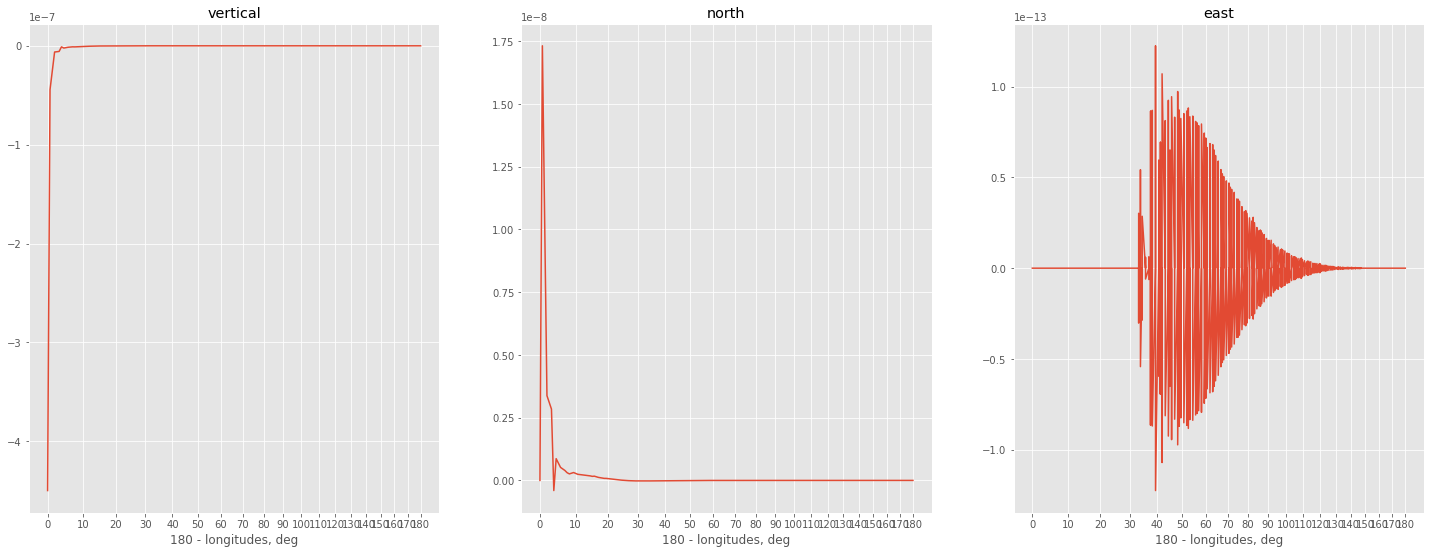

In [163]:
tol = np.radians(1.)
long = 0
#mask = (sph_crd[:,:,2] > (R_Earth - tol)) * (lon_ox < (np.radians(long)+tol) ) * (lon_ox > (np.radians(long)-tol) )
mask = (sph_crd[:,:,2] > (R_Earth - tol)) * (sph_crd[:,:,1] < (np.radians(long)+tol) ) * (sph_crd[:,:,1] > (np.radians(long)-tol) )
#lt = lat_ox[mask]
lt = np.pi - sph_crd[:,:,0][mask]
indx = np.argsort(lt)

components = ['vertical', 'north','east']

fig, ax = plt.subplots(1,3, figsize = (25,9))
for i,x in enumerate(ax):
    disp = displacement_rot[:,:,i][mask]
    print(np.max(abs(disp)))
    x.semilogx(np.degrees(lt[indx]) , disp[indx], '-')
    x.set_title(components[i])
    x.set_xlabel(f'180 - longitudes, deg')
    x.grid(visible=True, which='both', axis='both')
    x.set_xticks(np.arange(90,271,10))
    x.set_xticklabels(np.arange(0,181,10))

/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  after removing the cwd from sys.path.


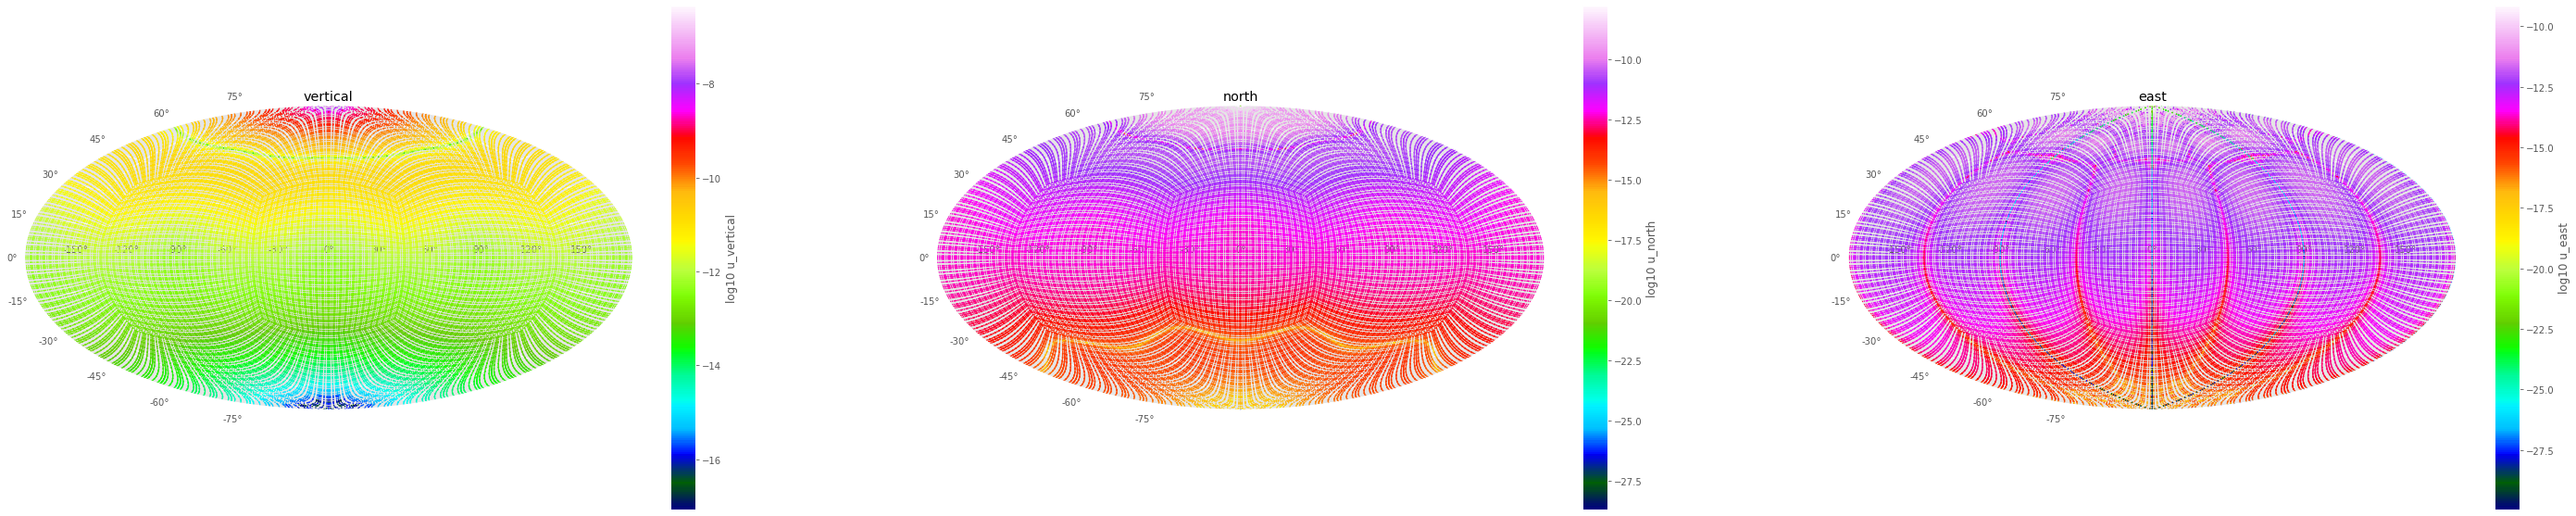

In [152]:
fig, ax = plt.subplots(1,3, figsize=(50,10), subplot_kw={"projection":'aitoff'})
for i, comp in enumerate(components):
    im = ax[i].scatter(sph_crd[:,:,1][mask], sph_crd[:,:,0][mask],  c=np.log10(np.abs(displacement_rot[:,:,i][mask])), s=1., cmap='gist_ncar')
    plt.colorbar(im, ax=ax[i], label=f'log10 u_{comp}', )
    ax[i].set( title=comp,)

**Calculating spherical harmonics coefficients for the Earth surface displacements**

In [132]:
mask = (sph_crd[:,:,2] > (R_Earth - tol)) 

order = 40
shexpans = np.zeros((2, order+1, order+1, dim))
for i in range(dim):
    shexpans[:,:,:,i], misfit = pysh.shtools.SHExpandLSQ(displacement_rot[:,:,i][mask], np.degrees(sph_crd[:,:,0][mask]), np.degrees(sph_crd[:,:,1][mask]), lmax=order)

**Plotting the spherical harmonic expansion**

Text(0.5, 1.0, 'C_l(m=0) expansion coefficients')

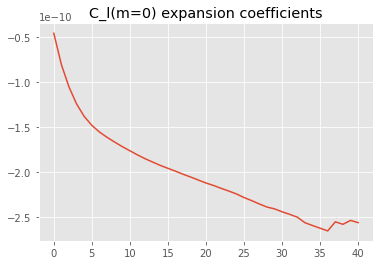

In [160]:
plt.plot(shexpans[0, :,0, 0])
plt.title("C_l(m=0) expansion coefficients")

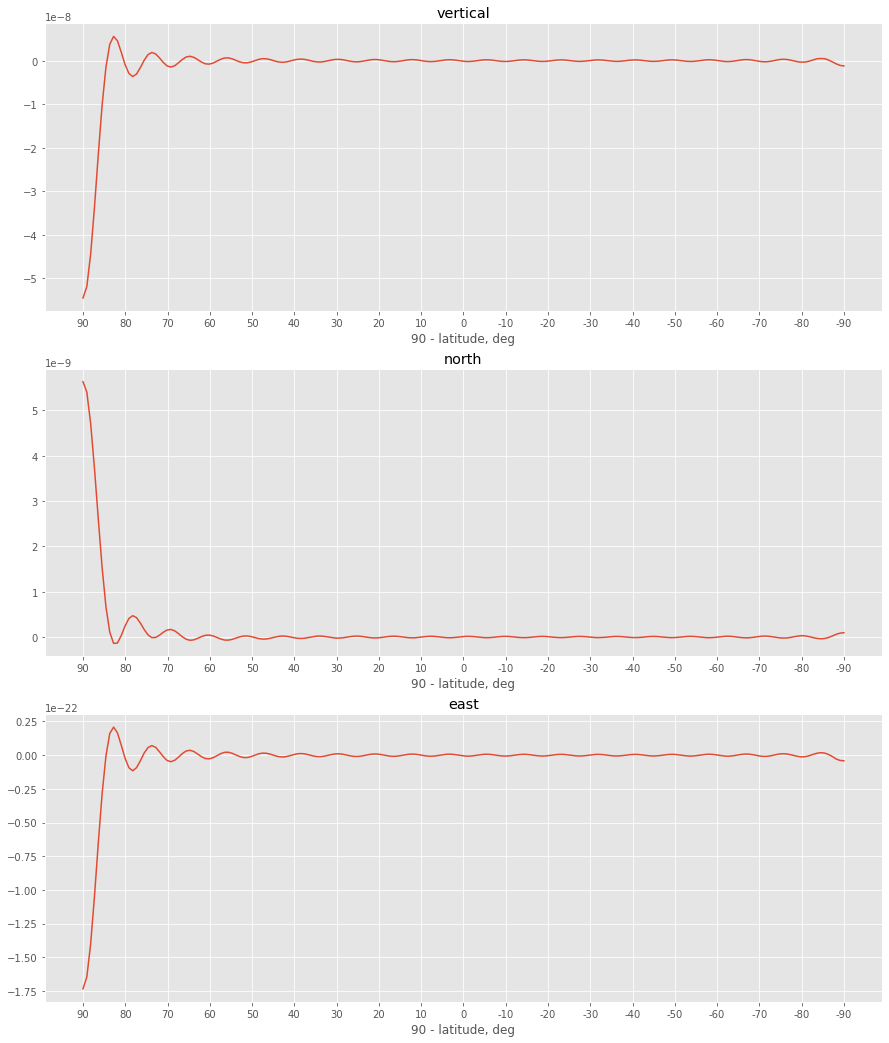

In [165]:
fig, ax = plt.subplots(dim,1, figsize = (15,18))
for i in range(dim):
    ls = np.linspace(0,180,200)
    sph_harm_exp = sph_harm_m0(shexpans[0, :,0, i])
    displ = [sph_harm_exp.subs('coslat', np.cos(np.radians(lat))) for lat in ls]
    ax[i].plot( ls, displ, '-')
    ax[i].set_title(components[i])
    ax[i].set_xlabel(f'90 - latitude, deg')
    ax[i].grid(visible=True, which='both', axis='both')
    ax[i].set_xticks(np.arange(0,181,10))
    ax[i].set_xticklabels(np.arange(90,-91,-10))

In [209]:
from sympy import legendre, Symbol, assoc_legendre, sin
def sph_harm_m0(coefs):
    expr = 0
    theta = Symbol('theta')
    N = coefs.shape[0]
    for l in range(N):
            expr += coefs[l] * assoc_legendre(l,0, sin(theta)) 
    return expr

In [212]:
expr = sph_harm_m0(shexpans[0, :,0, 0])

In [ ]:
mask = (sph_crd[:,:,2] > (R_Earth - tol)) 
reconstruction = np.array([expr.subs({'theta': np.radians(theta)}) for theta in sph_crd[:,:,0][mask]], dtype=np.float64)

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(10,10), subplot_kw={"projection":'aitoff'})
i=1
im = ax[i].scatter(sph_crd[:,:,1][mask], sph_crd[:,:,0][mask],  c=np.log10(np.abs(reconstruction)), s=1., cmap='gist_ncar')
plt.colorbar(im, ax=ax[i], label=f'log10 u_{comp}', )
ax[i].set( title=comp,)

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(50,10), subplot_kw={"projection":'aitoff'})
for i, comp in enumerate(components):
    im = ax[i].scatter(sph_crd[:,:,1][mask], sph_crd[:,:,0][mask],  c=np.log10(np.abs(displacement_rot[:,:,i][mask])), s=1., cmap='gist_ncar')
    plt.colorbar(im, ax=ax[i], label=f'log10 u_{comp}', )
    ax[i].set( title=comp,)